## Feature Engineering
- `is_poll` flag
- sentiment labeling
- `other_platform` mentioned tag

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans, DBSCAN

In [2]:
comments = pd.DataFrame()
posts = pd.DataFrame()

for file in os.listdir('./Data/comments/csv'):
    temp = pd.read_csv(f'./Data/comments/cleaned/{file}', low_memory=False)
    comments = pd.concat([comments, temp])
    
for file in os.listdir('./Data/posts/csv'):
    temp = pd.read_csv(f'./Data/posts/cleaned/{file}', low_memory=False)
    posts = pd.concat([posts, temp])

posts.dropna(axis=0, subset=['selftext'], inplace=True)
comments.dropna(axis=0, subset=['body'], inplace=True)

comments.reset_index(drop=False, names=['original_index'], inplace=True)
posts.reset_index(drop=False, names=['original_index'], inplace=True)

In [3]:
posts['is_poll'] = posts['poll_data'].apply(lambda x: False if x is np.nan else True)

In [4]:
def other_platform(record) -> bool:
    other_platforms = [
        'Depop', 'EtsySellers', 'Etsy', 
        'Flipping', 'Grailed', 'poshmark','stockx', 
        'Mercari', 'ThredUp', 'TheRealReal', 'TRR',
        'Ebay', 'FB Marketplace'
                       ]
    platform = posts.loc[record,'subreddit'].lower()
    other_platforms = [i.lower() for i in other_platforms if i.lower() != platform]
    all_text = str(posts.loc[record,'selftext']) + str(posts.loc[record,'author_flair_text']) + str(posts.loc[record,'poll_data'])
    for n in other_platforms:
        if n in all_text.lower():
            return True
    return False

In [5]:
posts['other_platform'] = [other_platform(x) for x in posts.index]

In [6]:
posts['other_platform'].value_counts()

other_platform
False    152925
True      34876
Name: count, dtype: int64

In [10]:
comments.dtypes

original_index         int64
subreddit_id          object
subreddit             object
subreddit_type        object
id                    object
parent_id             object
link_id               object
author                object
created_utc            int64
score                  int64
controversiality        bool
ups                  float64
likes                  int64
body                  object
author_flair_text     object
created               object
dtype: object

In [11]:
posts.dtypes

original_index        int64
subreddit            object
subreddit_id         object
subreddit_type       object
id                   object
name                 object
media                object
is_video               bool
created_utc           int64
num_comments          int64
score                 int64
ups                   int64
selftext             object
author_flair_text    object
link_flair_text      object
poll_data            object
created              object
is_poll                bool
other_platform         bool
dtype: object

In [12]:
posts.isnull().sum()

original_index            0
subreddit                 0
subreddit_id              0
subreddit_type        30924
id                        0
name                  59413
media                187790
is_video                  0
created_utc               0
num_comments              0
score                     0
ups                       0
selftext                  0
author_flair_text    172600
link_flair_text      102377
poll_data            186613
created                   0
is_poll                   0
other_platform            0
dtype: int64

### Polls
- `total_votes`
- `options_text`
- `options_weighting` _later_
- Use `author_flair_text` to indicate if:
  - someone is a marked buyer
  - someone is marked seller
  - someone adds their store tag _(improve)_

- Review `flair_tags` and generate further labels in combination with CVEC terms

In [108]:
sample_poll_1 = {
    'is_prediction': False, 
    'options': [
        {'id': '20094950', 'text': 'Goat', 'vote_count': 50},
        {'id': '20094951', 'text': 'Stockx', 'vote_count': 51}
        ],
    'prediction_status': None,
    'resolved_option_id': None,
    'total_stake_amount': None, 
    'total_vote_count': 101, 
    'tournament_id': None, 
    'user_selection': None, 
    'user_won_amount': None, 
    'vote_updates_remained': None, 
    'voting_end_timestamp': 1669935211731
    }

sample_poll_2 = {
    'options': [
        {'id': '83067', 
         'text': 'Only dropshipping is bad', 
         'vote_count': 44},
        {'id': '83068', 
         'text': 'Both are bad, but dropshipping significantly worse', 
         'vote_count': 74},
        {'id': '83069',
         'text': 'Both are equally bad',
         'vote_count': 50},
        {'id': '83070',
         'text': 'Neither are bad', 
         'vote_count': 7}
        ], 
    'total_vote_count': 175, 
    'user_selection': None, 
    'voting_end_timestamp': 1585745394498
    }


In [109]:
posts['poll_votes'] = posts['poll_data'].apply(lambda x: eval(x)['total_vote_count'] if isinstance(x, str) else 0)

In [263]:
posts['author_flair_text'].fillna('-', inplace=True)
comments['author_flair_text'].fillna('-', inplace=True)

C:\Users\sonya\AppData\Local\Temp\ipykernel_7308\2661875794.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  posts['author_flair_text'].fillna('-', inplace=True)
C:\Users\sonya\AppData\Local\Temp\ipykernel_7308\2661875794.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

In [264]:
posts['buyer'] = [1 if 'buyer' in x.lower() else 0 for x in posts['author_flair_text']]
posts['seller'] = [1 if 'seller' in x.lower() else 0 for x in posts['author_flair_text']]
posts['shop_tag'] = [1 if ('@' in x.lower()) | ('etsy' in x.lower()) | ('depop' in x.lower()) else 0 for x in posts['author_flair_text']]

comments['buyer'] = [1 if 'buyer' in x.lower() else 0 for x in comments['author_flair_text']]
comments['seller'] = [1 if 'seller' in x.lower() else 0 for x in comments['author_flair_text']]

In [98]:
def poll_options(poll_data: str) -> str:
    if isinstance(poll_data, str):
        poll_data = eval(str(poll_data))
        options = [i['text'] for i in poll_data['options']]
        return ', '.join(options)

In [99]:
# posts['poll_options'] = posts['poll_data'].apply(lambda x: poll_options(x) if isinstance(x, str) else None)
posts['poll_options'] = posts['poll_data'].apply(poll_options)

### Topic Generation
- Creating list of general topics with simple text processing and `CVEC`

In [3]:
posts = pd.read_csv('./Data/preprocessed/posts.csv', low_memory=False)
comments = pd.read_csv('./Data/preprocessed/comments.csv', low_memory=False)

C:\Users\sonya\AppData\Local\Temp\ipykernel_7308\1494977186.py:1: DtypeWarning: Columns (7,16,21) have mixed types. Specify dtype option on import or set low_memory=False.
  posts = pd.read_csv('./Data/preprocessed/posts.csv')
C:\Users\sonya\AppData\Local\Temp\ipykernel_7308\1494977186.py:2: DtypeWarning: Columns (4,15) have mixed types. Specify dtype option on import or set low_memory=False.
  comments = pd.read_csv('./Data/preprocessed/comments.csv')


In [7]:
## Original/simple processor function

# def remove_stopwords(sentence: str) -> str:
#     stopwords_ = stopwords.words('english')
#     sentence = sentence.split(' ')
#     output = [word for word in sentence if word.lower() not in stopwords_]
#     return ' '.join(output).replace('\n', ' ').strip()

In [16]:
posts.dropna(subset='selftext', inplace=True)

In [17]:
# 

tokenizer = RegexpTokenizer(r'[A-Za-z]+')
lemmatizer = WordNetLemmatizer()
all_stopwords = stopwords.words('english') + [
    'anyone','someone','everyone','everybody',
    'also','you','your','etsy','depop','grailed','ebay','stockx',
    'http','www','com','reddit'] + posts['subreddit'].unique()

def post_processor(sentence: str, tokenizer, lemmatizer, stopwords) -> str:

    tokenized = tokenizer.tokenize(sentence.lower())
    lemmatized = [lemmatizer.lemmatize(i) for i in tokenized]
    no_stopwords = [w for w in lemmatized if w not in all_stopwords]
    return ' '.join(no_stopwords).replace('\n', ' ').strip()
    
j = 0
total_posts = len(posts)
cleaned_posts = []
for post in posts['selftext']:
    cleaned_posts.append(post_processor(post, tokenizer, lemmatizer, all_stopwords))

posts['cleaned_text'] = cleaned_posts

In [271]:
vectorizer_topics = CountVectorizer(
    analyzer='word',
    tokenizer=None,
    preprocessor=None,
    stop_words=None,
    max_features=500,
    # no min_df needed with 2, 3grams
    # min_df=0.1, # no need to set max_df based on initial output
    ngram_range=(2)
)
output_phrases = vectorizer_topics.fit_transform(cleaned_posts)
topics_counts = pd.DataFrame(output_phrases.toarray(),
                             columns=vectorizer_topics.get_feature_names_out()).sum().sort_values(
                                 ascending=False)

In [272]:
topics = {
    'customer': ['buyer','customer'],
    'item': ['item','product'],
    'selling': ['sell','selling','seller','profit'],
    'order': ['sale','sold','purchase','order'],
    'return': ['refund','return','get money back'],
    'problem': ['case', 'issue', 'bad review'],
    'money/payment': ['money','paypal','offer','price','pay','fee','cost'],
    'listing': ['listing','post','description','descript','describe'],
    'flipping': ['flip','flipping','resale','resold','resell'],
    'account': ['account','review','store','shop','business'],
    'images': ['photo', 'picture','pictures','image','images'],
    'shipping': ['shipping','ship','sent','package','shipped','label','tracking','send', 'post office','free shipping','received', 'usps'],
    'advice': ['advice','look','looking','search'],
    # 'full time': ['full time', 'fulltime'],
    # 'part time': ['part time', 'parttime']
}

all_topics = []
# want to include both text body and poll options only for topic labeling
# not for future sentiment labeling
# thus, done in this step and not preprocessing
cleantext_w_polloptions = posts['cleaned_text']+posts['poll_options'].fillna('')

# [posts[f'{i}'] for i in topics.keys()]

def topic_labeler(sentence: str, topics: dict) -> bool:
    output_ = {}
    for topic, terms in topics.items():
        output_[topic] = any(map(lambda v: v in sentence.split(' '), terms))
    return output_

topic_matrix = [topic_labeler(sentence, topics=topics) for sentence in cleantext_w_polloptions]
topic_df = pd.DataFrame(topic_matrix)
topic_df['topic_count'] = topic_df.sum(axis=1)

In [273]:
all_topics = []
[all_topics.extend(i) for i in topics.values()]
topics_counts.drop(index = [i for i in topics_counts.index if i in all_topics])

feel like         7786
wa wondering      6380
would like        5524
shipping label    5220
let know          5026
                  ... 
need get           634
gift card          632
told would         631
fb marketplace     630
seller buyer       630
Length: 496, dtype: int64

In [242]:
topic_df.sum().sort_values(ascending=False)/len(topic_df)

topic_count      3.316420
selling          0.409093
order            0.400419
item             0.387096
shipping         0.374210
account          0.358299
money/payment    0.331644
listing          0.243353
customer         0.227091
advice           0.219493
problem          0.114595
return           0.101725
images           0.092263
flipping         0.057140
dtype: float64

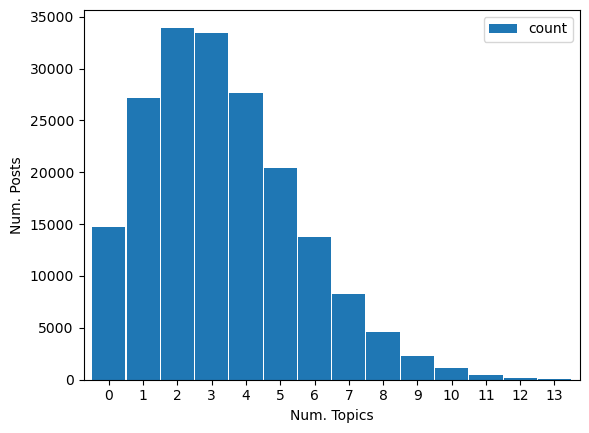

In [243]:
pd.DataFrame(topic_df['topic_count'].value_counts().sort_index()).plot(kind='bar', 
                                                         rot=0.5,
                                                         xlabel='Num. Topics',
                                                         ylabel='Num. Posts',
                                                         use_index=True,
                                                         width=0.97
                                                         );

In [ ]:
posts_w_topics = pd.merge(posts, pd.DataFrame(topic_matrix), left_index=True, right_index=True)

In [292]:
clustering_vectorizer = CountVectorizer(
    analyzer='word',
    tokenizer=None,
    preprocessor=None,
    stop_words=None,
    max_features=10_000,
    min_df=0.2,
    ngram_range=(1,3)
)
output_phrases = clustering_vectorizer.fit_transform(cleaned_posts)
topics_counts = pd.DataFrame(output_phrases.toarray(),
                             columns=clustering_vectorizer.get_feature_names_out()).sum().sort_values(
                                 ascending=False)

- follow up on "free" and "post"

In [293]:
clustering = KMeans(n_clusters=7, random_state=42).fit(output_phrases)
posts['cluster'] = clustering.labels_

In [294]:
clustering.get_feature_names_out()

array(['kmeans0', 'kmeans1', 'kmeans2', 'kmeans3', 'kmeans4', 'kmeans5',
       'kmeans6'], dtype=object)

In [295]:
posts['cluster'].value_counts().sort_index()/len(posts)

cluster
0    0.154200
1    0.014025
2    0.090447
3    0.114898
4    0.525610
5    0.051922
6    0.048898
Name: count, dtype: float64

<Axes: ylabel='cluster'>

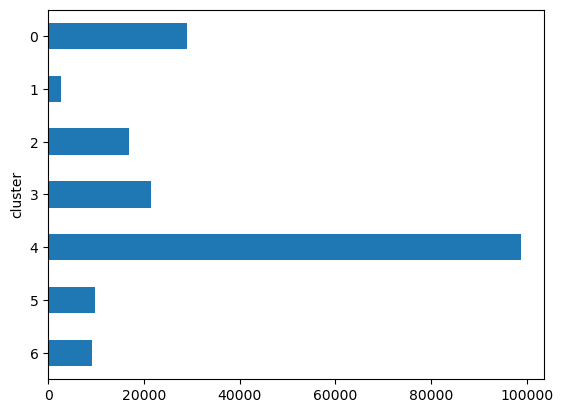

In [296]:
posts['cluster'].value_counts().sort_index(ascending=False).plot(kind='barh')

In [261]:
posts.columns

Index(['Unnamed: 0', 'original_index', 'subreddit', 'subreddit_id',
       'subreddit_type', 'id', 'name', 'media', 'is_video', 'created_utc',
       'num_comments', 'score', 'ups', 'selftext', 'author_flair_text',
       'link_flair_text', 'poll_data', 'created', 'is_poll', 'other_platform',
       'poll_votes', 'poll_options', 'cleaned_text', 'cluster'],
      dtype='object')

In [276]:
topic_df['cluster'] = clustering.labels_
topic_df['is_seller'] = posts['other_platform']


In [306]:
topic_df.groupby(by='cluster').sum()

,customer,item,selling,order,return,problem,money/payment,listing,flipping,account,images,shipping,advice,topic_count,is_seller
cluster,,,,,,,,,,,,,,,
0,6129,10431,13760,12016,2076,2914,10109,8126,1926,11942,3235,9504,9025,101193,5778
1,54,70,68,70,34,41,61,62,29,63,42,53,57,704,14
2,1159,1887,1466,1469,735,715,1373,1121,284,1163,595,1448,884,14299,379
3,7621,29092,12391,12993,3171,3075,11134,7448,1516,9241,2321,12597,5274,117874,5004
4,11698,5408,25697,24949,4288,5632,19501,14055,3710,24965,4790,23172,13124,180989,15617
5,3074,4762,5875,4885,1331,1635,4748,3297,932,5003,1341,4661,3630,45174,2185
6,4347,10357,6253,6113,2161,2062,5373,4014,787,4429,1530,5839,2957,56222,1948
7,2466,3266,3084,3319,1758,1821,2864,2255,462,2803,1161,3436,1866,30561,847
8,5774,6987,7793,8934,3274,3301,6697,4986,958,7266,2086,9130,4089,71275,3007


In [194]:
# checking for subfolder, if not create
if not os.path.exists(f"./Data/preprocessed/"):
    os.makedirs("./Data/preprocessed/") 
# exporting CSV
posts.to_csv('./Data/preprocessed/posts.csv')
comments.to_csv('./Data/preprocessed/comments.csv')
posts[['id','selftext']].to_csv('./Data/preprocessed/posts_sentiment_data.csv', index=False)

In [307]:
posts[posts['poll_votes']>0]['poll_votes'].sum()

218798

In [305]:
posts['is_poll'].value_counts()

is_poll
0    177071
1     10730
Name: count, dtype: int64

In [314]:
posts[posts['poll_votes']>0].groupby(by='subreddit')['is_poll'].sum()

subreddit
Depop          927
EtsySellers    143
Flipping         6
Grailed          2
poshmark        71
stockx          38
Name: is_poll, dtype: int64

In [319]:
posts[posts.is_poll==1]['poll_votes'].value_counts()

poll_votes
-1      9542
 187      14
 136      12
 137      12
 134      11
        ... 
 250       1
 402       1
 549       1
 406       1
 13        1
Name: count, Length: 351, dtype: int64

In [322]:
posts[posts['poll_votes']>0].is_poll.value_counts()

is_poll
1    1187
Name: count, dtype: int64

In [323]:
218798/1187

184.3285593934288